<a href="https://colab.research.google.com/github/scottblender/twitter-covid-19-vaccine-analysis/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import os
import numpy as np
import pandas as pd

# ML toolkits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils.extmath import density
from sklearn.pipeline import make_pipeline

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

In [59]:

Tweets = pd.read_csv('Tweets_Random_Sample.csv')

In [60]:
Tweets['Misinformation_Score']= np.where(Tweets.Misinformation_Score >= 0.5, 1, Tweets.Misinformation_Score)

In [61]:
Tweets['Misinformation_Score']= np.where(Tweets.Misinformation_Score < 0.5, 0, Tweets.Misinformation_Score)

In [62]:
Tweets.head()

,Unnamed: 0,Unnamed: 0.1,Datetime,Tweet Id,Text,Username,Verified,Followers Count,Friends Count,Like Count,Retweet Count,Quote Count,Created,Location,Display Name,Language,Coordinates,Place,Text_No_Usernames,Text_No_Links,Text_Punc,Text_Stop,Text_Tokenized,Text_Lemmatized,Unnamed: 24,Misinformation_Score
0,44685,44684,2021-05-19 04:56:48+00:00,1.390000e+18,guys the covid vaccine makes your ass fatter!!!!,Battle_Plays,False,955,907,15,3,0,2017-12-30 20:42:07+00:00,The Big MT,Battle,en,NaN,NaN,guys the covid vaccine makes your ass fatter!!!!,guys the covid vaccine makes your ass fatter!!!!,guys the covid vaccine makes your ass fatter,guys covid vaccine makes ass fatter,"['guys', 'covid', 'vaccine', 'makes', 'ass', '...","['guy', 'covid', 'vaccine', 'make', 'as', 'fat...",NaN,1.0
1,917945,69272,2021-05-06 00:09:34+00:00,1.390000e+18,i was given the polio vaccine when i was a kid...,zgrammyz,False,1626,2559,0,0,0,2016-05-13 21:34:08+00:00,NaN,Shari,en,NaN,NaN,i was given the polio vaccine when i was a kid...,i was given the polio vaccine when i was a kid...,i was given the polio vaccine when i was a kid...,given polio vaccine kid 15 years later unusual...,"['given', 'polio', 'vaccine', 'kid', '15', 'ye...","['given', 'polio', 'vaccine', 'kid', '15', 'ye...",NaN,1.0
2,237373,70703,2021-05-16 01:25:37+00:00,1.390000e+18,@hardtnoah @bgoochy @dan_bernstein well it’s a...,notmarkwalsh,False,387,358,1,0,0,2009-03-18 23:35:24+00:00,Fishtown,m a r k. Ⓥ,en,NaN,NaN,well it’s a good thing the covid vaccine isn’t...,well it’s a good thing the covid vaccine isn’t...,well its a good thing the covid vaccine isnt t...,well good thing covid vaccine isnt anthrax vac...,"['well', 'good', 'thing', 'covid', 'vaccine', ...","['well', 'good', 'thing', 'covid', 'vaccine', ...",NaN,1.0
3,1186072,89616,2021-05-04 08:42:33+00:00,1.390000e+18,@jpnadda @bjp4india 😂🤣🤣🤣🤣🤣u r not doing any fa...,sy_sadat,False,25,98,0,0,0,2015-01-08 18:34:22+00:00,DXB,TrueFactor,en,NaN,NaN,😂🤣🤣🤣🤣🤣u r not doing any favour every1 r #india...,😂🤣🤣🤣🤣🤣u r not doing any favour every1 r #india...,u r not doing any favour every1 r indians ur d...,u r favour every1 r indians ur divisivepolitic...,"['u', 'r', 'favour', 'every1', 'r', 'indians',...","['u', 'r', 'favour', 'every1', 'r', 'indian', ...",NaN,1.0
4,31756,31756,2021-05-20 11:07:49+00:00,1.400000e+18,@herdimmunityph @drtonyleachon hi doc @drtonyl...,jarygregorio,False,10,149,1,0,0,2020-10-21 15:28:33+00:00,Philippines,Jary Gregorio,en,NaN,NaN,"hi doc , i just had my last booster shot for...","hi doc , i just had my last booster shot for...",hi doc i just had my last booster shot for an...,hi doc last booster shot antirabies vaccine la...,"['hi', 'doc', 'last', 'booster', 'shot', 'anti...","['hi', 'doc', 'last', 'booster', 'shot', 'anti...",NaN,0.0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(Tweets['Text_Punc'], Tweets['Misinformation_Score'], test_size=0.25)

In [64]:
display(X_train.head())
print('\n')
display(y_train.head())

print("\nThere are {} documents in the training data.".format(len(X_train)))

358                  got my second dose of covid vaccine
135    they havent gotten a covid vaccine yet but the...
71     is there any youtube video on making covid vac...
426    covid vaccine efficacy rates and the origins o...
132    cant do it correctly oh privatized healthcare ...
Name: Text_Punc, dtype: object

358    0.0
135    0.0
71     1.0
426    0.0
132    1.0
Name: Misinformation_Score, dtype: float64


There are 375 documents in the training data.


In [65]:
my_tfidf = TfidfVectorizer(stop_words='english', max_df=0.8)

# fit the vectorizer and transform X_train into a tf-idf matrix,
# then use the same vectorizer to transform X_test
tfidf_train = my_tfidf.fit_transform(X_train)
tfidf_test = my_tfidf.transform(X_test)
tfidf_train

<375x2433 sparse matrix of type '<class 'numpy.float64'>'
	with 4899 stored elements in Compressed Sparse Row format>

In [66]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa_clf = PassiveAggressiveClassifier(max_iter=50)
pa_clf.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

The accuracy of prediction is 65.60%.

The F1 score is 0.377.



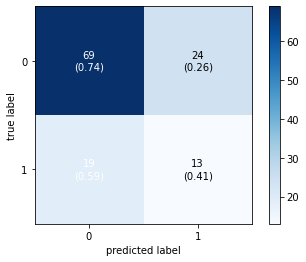

In [67]:
y_pred = pa_clf.predict(tfidf_test)

conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat,
                      show_normed=True, colorbar=True)

accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test,y_pred)

print('The accuracy of prediction is {:.2f}%.\n'.format(accscore*100))
print('The F1 score is {:.3f}.\n'.format(f1score))

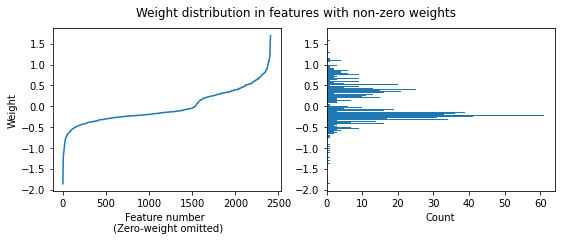

In [68]:
# Sort non-zero weights
weights_nonzero = pa_clf.coef_[pa_clf.coef_!=0]
feature_sorter_nonzero = np.argsort(weights_nonzero)
weights_nonzero_sorted =weights_nonzero[feature_sorter_nonzero]

# Plot
fig, axs = plt.subplots(1,2, figsize=(9,3))

sns.lineplot(data=weights_nonzero_sorted, ax=axs[0])
axs[0].set_ylabel('Weight')
axs[0].set_xlabel('Feature number \n (Zero-weight omitted)')

axs[1].hist(weights_nonzero_sorted,
            orientation='horizontal', bins=500,)
axs[1].set_xlabel('Count')

fig.suptitle('Weight distribution in features with non-zero weights')

plt.show()

In [69]:
# Sort features by their associated weights
tokens = my_tfidf.get_feature_names()
tokens_nonzero = np.array(tokens)[pa_clf.coef_[0]!=0]
tokens_nonzero_sorted = np.array(tokens_nonzero)[feature_sorter_nonzero]

num_tokens = 10
true_information_indicator_tokens = tokens_nonzero_sorted[:num_tokens]
misinformation_indicator_tokens = np.flip(tokens_nonzero_sorted[-num_tokens:])

misinformation_indicator = pd.DataFrame({
    'Token': misinformation_indicator_tokens,
    'Weight': weights_nonzero_sorted[:num_tokens]
})

true_information_indicator = pd.DataFrame({
    'Token': true_information_indicator_tokens,
    'Weight': np.flip(weights_nonzero_sorted[-num_tokens:])
})

print('The top {} tokens likely to appear in misinformation were the following: \n'.format(num_tokens))
display(misinformation_indicator)

print('\n\n...and the top {} tokens likely to appear in true information were the following: \n'.format(num_tokens))
display(true_information_indicator)

The top 10 tokens likely to appear in misinformation were the following: 



,Token,Weight
0,need,-1.861680
1,isnt,-1.382976
2,fuck,-1.371890
3,asia,-1.301181
4,actual,-1.230282
5,worse,-1.189369
6,deaths,-1.147581
7,industry,-1.142735
8,certificate,-1.141282
9,effect,-1.112357




...and the top 10 tokens likely to appear in true information were the following: 



,Token,Weight
0,dose,1.697992
1,12,1.582525
2,covidvaccine,1.562577
3,vaccination,1.555631
4,soon,1.474721
5,thats,1.297276
6,use,1.292078
7,help,1.256279
8,pandemic,1.210067
9,calm,1.181060


In [70]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
regression = LogisticRegression()
regression.fit(tfidf_train,y_train)
y_pred = regression.predict(tfidf_test)

The accuracy of prediction is 74.40%.

The F1 score is 0.000.



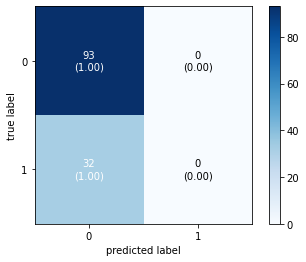

In [71]:
conf_mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat,
                      show_normed=True, colorbar=True)

accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test,y_pred)
print('The accuracy of prediction is {:.2f}%.\n'.format(accscore*100))
print('The F1 score is {:.3f}.\n'.format(f1score))

In [72]:
Tweets_May = pd.read_csv('Tweets_May_Cleaned.csv')

In [73]:
tfidf_test = my_tfidf.transform(Tweets_May['Text_Punc'])

In [74]:
y_pred = pa_clf.predict(tfidf_test)

In [75]:
Tweets_May['Misinformation_Class'] = y_pred
Tweets_May.head()

,Unnamed: 0,Unnamed: 0.1,Datetime,Tweet Id,Text,Username,Verified,Followers Count,Friends Count,Like Count,Retweet Count,Quote Count,Created,Location,Display Name,Language,Coordinates,Place,Text_No_Usernames,Text_No_Links,Text_Punc,Text_Stop,Text_Tokenized,Text_Lemmatized,Misinformation_Class
0,0,0,2021-05-23 23:59:57+00:00,1.396617e+18,if we're going to mock people who report side ...,shawna_burley,False,5387.0,1957.0,29.0,4.0,1.0,2016-07-29 02:58:29+00:00,"Oklahoma, USA",Shawna Burley 🌺,en,NaN,NaN,if we're going to mock people who report side ...,if we're going to mock people who report side ...,if were going to mock people who report side e...,going mock people report side effects result c...,"['going', 'mock', 'people', 'report', 'side', ...","['going', 'mock', 'people', 'report', 'side', ...",1.0
1,1,1,2021-05-23 23:59:38+00:00,1.396617e+18,virgin's richard branson urges australians to ...,BabushkaThe,False,645.0,4602.0,0.0,0.0,0.0,2016-02-03 21:31:35+00:00,Anglosphere,☀️TheRealBabushka ☀️,en,NaN,NaN,virgin's richard branson urges australians to ...,virgin's richard branson urges australians to ...,virgins richard branson urges australians to g...,virgins richard branson urges australians get ...,"['virgins', 'richard', 'branson', 'urges', 'au...","['virgin', 'richard', 'branson', 'urge', 'aust...",1.0
2,3,3,2021-05-23 23:59:08+00:00,1.396617e+18,#palestinians can't even get a #covidvaccine o...,SilverForest155,False,1284.0,1406.0,0.0,1.0,0.0,2021-03-29 13:59:25+00:00,NaN,Silver Forest,en,NaN,NaN,#palestinians can't even get a #covidvaccine o...,#palestinians can't even get a #covidvaccine o...,palestinians cant even get a covidvaccine or e...,palestinians cant even get covidvaccine even t...,"['palestinians', 'cant', 'even', 'get', 'covid...","['palestinian', 'cant', 'even', 'get', 'covidv...",0.0
3,4,4,2021-05-23 23:59:06+00:00,1.396617e+18,@peterhotez the percentage of adults in canada...,LloydOsten,False,412.0,285.0,0.0,0.0,0.0,2015-09-27 12:24:55+00:00,NaN,Lloyd Osten,en,NaN,NaN,the percentage of adults in canada who have r...,the percentage of adults in canada who have r...,the percentage of adults in canada who have r...,percentage adults canada received one dose cov...,"['percentage', 'adults', 'canada', 'received',...","['percentage', 'adult', 'canada', 'received', ...",0.0
4,5,5,2021-05-23 23:58:13+00:00,1.396616e+18,is it bad to wait until the fda approves the c...,juhnesuh,False,2448.0,2124.0,0.0,0.0,0.0,2011-06-20 02:00:40+00:00,NaN,paragon,en,NaN,NaN,is it bad to wait until the fda approves the c...,is it bad to wait until the fda approves the c...,is it bad to wait until the fda approves the c...,bad wait fda approves covid vaccine get cause ...,"['bad', 'wait', 'fda', 'approves', 'covid', 'v...","['bad', 'wait', 'fda', 'approves', 'covid', 'v...",0.0


In [76]:
pip install vaderSentiment


In [77]:
pip install plotly

In [78]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

In [79]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
new_words = {
    'cpos': -3.0,
    'cneg': 3.0,
}
analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(new_words)
scores=[]
for i in range(len(Tweets_May['Text_Lemmatized'])):
    
    score = analyser.polarity_scores(Tweets_May['Text_Lemmatized'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.75:
        sentiment.append('Overly Positive')
    elif (i>=0.05) and (i<0.75):
        sentiment.append('Positive')
    elif i<=(-0.75):
        sentiment.append('Overly Negative')
    elif (i<=-0.05) and (i>-0.75):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
Tweets_May['sentiment']= pd.Series(np.array(sentiment))

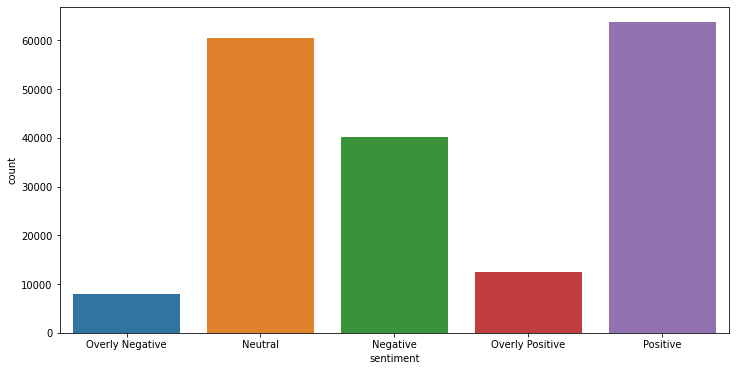

In [80]:
temp = Tweets_May.groupby('sentiment').count()['Text_Lemmatized'].reset_index().sort_values(by='Text_Lemmatized',ascending=False)
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=Tweets_May)
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.Text_Lemmatized,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [81]:
[a,b,c,d]= Tweets_May.groupby(['Verified', 'Misinformation_Class']).size()

In [82]:
percent_misinformation_not_verified = (b / (a+ b))* 100
percent_good_information_not_verified = (a / (a+ b))* 100
percent_misinformation_verified = (d / (c+ d))* 100
percent_good_information_verified = (c / (c+ d))* 100
print('The percentage of tweets that are classified as misinformation from non-verified accounts are ' + str(percent_misinformation_not_verified) + '%')
print('The percentage of tweets that are classified as regular information from non-verified accounts are ' + str(percent_good_information_not_verified) + '%')
print('The percentage of tweets that are classified as misinformation from verified accounts are ' + str(percent_misinformation_verified) + '%')
print('The percentage of tweets that are classified as regular information from verified accounts are ' + str(percent_good_information_verified) + '%')

The percentage of tweets that are classified as misinformation from non-verified accounts are 20.54175152749491%
The percentage of tweets that are classified as regular information from non-verified accounts are 79.45824847250509%
The percentage of tweets that are classified as misinformation from verified accounts are 15.226748654880861%
The percentage of tweets that are classified as regular information from verified accounts are 84.77325134511914%


In [83]:
[a,b,c,d]= Tweets_May.groupby(['Verified', 'Misinformation_Class'])

In [84]:
a

((False, 0.0),
         Unnamed: 0  Unnamed: 0.1  ... Misinformation_Class        sentiment
 2                3             3  ...                  0.0         Negative
 3                4             4  ...                  0.0          Neutral
 4                5             5  ...                  0.0         Negative
 5                6             6  ...                  0.0  Overly Positive
 6                7             7  ...                  0.0          Neutral
 ...            ...           ...  ...                  ...              ...
 184854     1248096         99994  ...                  0.0         Positive
 184856     1248099         99997  ...                  0.0  Overly Negative
 184857     1248100         99998  ...                  0.0         Positive
 184858     1248101         99999  ...                  0.0         Positive
 184859     1248102        100000  ...                  0.0         Positive
 
 [136549 rows x 26 columns])

In [85]:
a1 = a[1]['Retweet Count'].sum()
print('The number of retweets from accounts that are  classified as misinformation from nonverified accounts is ' + str(a1))
b1 = b[1]['Retweet Count'].sum()
print('The number of retweets from accounts that are not classified as misinformation from nonverified accounts is ' + str(b1))
c1 = c[1]['Retweet Count'].sum()
print('The number of retweets from accounts that are  classified as misinformation from verified accounts is ' + str(c1))
d1 = d[1]['Retweet Count'].sum()
print('The number of retweets from accounts that are not classified as misinformation from verified accounts is ' + str(d1))

The number of retweets from accounts that are  classified as misinformation from nonverified accounts is 170799.0
The number of retweets from accounts that are not classified as misinformation from nonverified accounts is 64478.0
The number of retweets from accounts that are  classified as misinformation from verified accounts is 149401.0
The number of retweets from accounts that are not classified as misinformation from verified accounts is 53032.0


In [86]:
from collections import Counter

In [87]:
c = Counter(y_pred)
x = c[0.0] 
y = c[1.0]

In [88]:
percent_good_information = (x/(x+y))* 100

In [89]:
percent_misinformation = (y/(x+y))* 100

In [90]:
print(str(percent_good_information) + '%')

79.83230552850806%


In [91]:
print(str(percent_misinformation) + "%")

20.16769447149194%


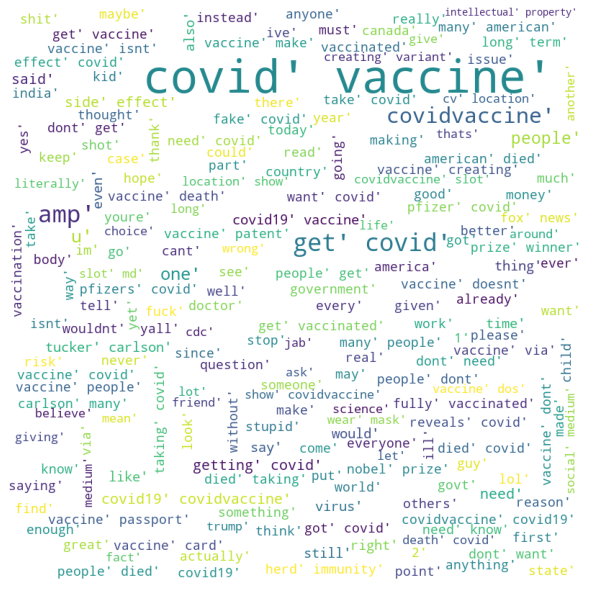

In [92]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
Tweets_May_Misinformation = Tweets_May[Tweets_May['Misinformation_Class'] == 1.0]
Text = ' '.join(Tweets_May_Misinformation['Text_Lemmatized'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(Text)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

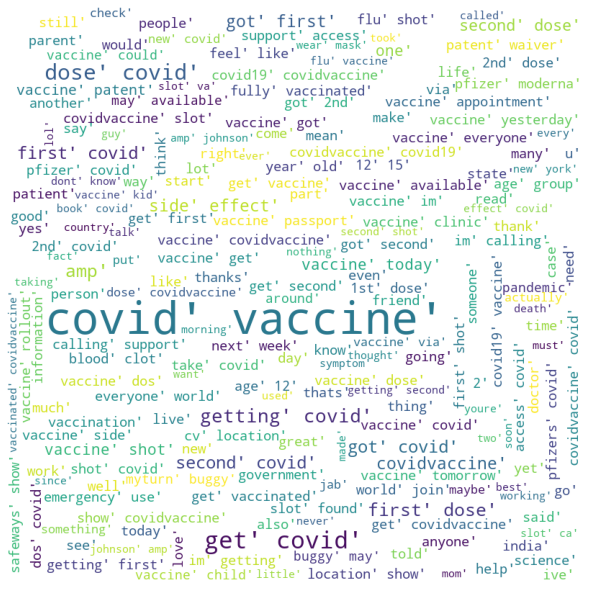

In [93]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
Tweets_May_Regular_Information = Tweets_May[Tweets_May['Misinformation_Class'] == 0.0]
Text = ' '.join(Tweets_May_Regular_Information['Text_Lemmatized'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(Text)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()